In [293]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pprint

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPRegressor

In [347]:
# Nim's parameters

SIZE_BIN = 20
MAX_TAKE = 3

POSSIBLE_STATES = list(range(1, SIZE_BIN+1))
POSSIBLE_ACTIONS = list(range(1, MAX_TAKE+1))

In [389]:
# Initializing model with a first mini-batch
model = MLPRegressor(
    max_iter = 1000,
    tol = 1e-5,
    learning_rate='invscaling'
)
#     hidden_layer_sizes=(30,),

X_init = np.array(POSSIBLE_STATES).reshape(-1, 1)
default_target = []
default_target = [1] + [0]*(len(POSSIBLE_ACTIONS)-1)
y_init = np.array([default_target]*len(POSSIBLE_STATES))

model = model.partial_fit(X_init, y_init)

X_init.shape, np.array(y_init).shape

((20, 1), (20, 3))

In [395]:
# Showing chosen action for each possible state
for possible_state in POSSIBLE_STATES:
    chosen_action = model.predict(possible_state)
    print possible_state, chosen_action, np.argmax(chosen_action)+1

1 [[ 0.04171096  0.03156471  0.08458685]] 3
2 [[ 0.01837306  0.00626456  0.12255725]] 3
3 [[-0.00706971 -0.03568727  0.09608911]] 3
4 [[-0.00306677 -0.05271086 -0.03946113]] 1
5 [[ 0.0572652  -0.02716813 -0.03073965]] 1
6 [[ 0.04239039 -0.02056064 -0.02058461]] 1
7 [[ 0.03091764 -0.01546438 -0.01275215]] 1
8 [[ 0.03091764 -0.01546438 -0.01275215]] 1
9 [[ 0.03091764 -0.01546438 -0.01275215]] 1
10 [[ 0.03091764 -0.01546438 -0.01275215]] 1
11 [[ 0.03091764 -0.01546438 -0.01275215]] 1
12 [[ 0.03091764 -0.01546438 -0.01275215]] 1
13 [[ 0.03091764 -0.01546438 -0.01275215]] 1
14 [[ 0.03091764 -0.01546438 -0.01275215]] 1
15 [[ 0.03091764 -0.01546438 -0.01275215]] 1
16 [[ 0.03091764 -0.01546438 -0.01275215]] 1
17 [[ 0.03091764 -0.01546438 -0.01275215]] 1
18 [[ 0.03091764 -0.01546438 -0.01275215]] 1
19 [[ 0.03091764 -0.01546438 -0.01275215]] 1
20 [[ 0.03091764 -0.01546438 -0.01275215]] 1


In [391]:
def random_action():
    return np.random.randint(1, MAX_TAKE+1)


def player_move_and_win_check(state, player_is_random):
    # Player move
    if player_is_random:
        action = random_action()
    else:
        qval = model.predict(state)
        action = np.argmax(qval)+1
    new_state = state - action
    
    # Win check
    if new_state <= 0:
        # Player win
        games.append(1)
        if player_is_random:
            random_games.append(1)
        else:
            chosen_games.append(1)
        return 0, action, False, 1
    else:
        return new_state, action, True, 0

def adversary_move_and_win_check(state):
    if state <= MAX_TAKE:
        # Adversary wins
        games.append(-1)
        if player_is_random:
            random_games.append(-1)
        else:
            chosen_games.append(-1)
        return 0, MAX_TAKE, False, -1
    else:
        adversary_action = random_action()
        return state - adversary_action, adversary_action, True, 0

def add_to_plays_description(player_is_random, player_first, player_won, nb_rounds):
    play_type = 'random_play' if player_is_random else 'chosen_play'
    player_sequence = 'player_first' if player_first else 'player_second'
    play_outcome = 'win' if player_won else 'loss'
    plays_description[play_type][player_sequence][play_outcome] += 1
    plays_description[play_type][player_sequence]['#rounds'] += nb_rounds

In [392]:
nb_epochs = 20000
logging_rate = int(nb_epochs/10)
random_plays = 0
chosen_plays = 0
epsilon = 0.5
games = []
random_games = []
chosen_games = []
update_stages = defaultdict(int)
plays_description = {
    'random_play':{
        'player_first':{
            'win': 0,
            'loss': 0,
            '#rounds': 0
        },
        'player_second':{
            'win': 0,
            'loss': 0,
            '#rounds': 0
        }
    },
    'chosen_play':{
        'player_first':{
            'win': 0,
            'loss': 0,
            '#rounds': 0
        },
        'player_second':{
            'win': 0,
            'loss': 0,
            '#rounds': 0
        }
    }
}
    

for i in range(nb_epochs):
    if i % logging_rate == 0:
        print i
    
    # Initializing the game
    state = SIZE_BIN
    tmp_states = []
    still_going = True
    reward = 0
    update = 0
    player_is_random = random.random() < epsilon
    player_first = np.random.choice([True, False])
    if player_is_random:
        random_plays += 1
    else:
        chosen_plays += 1
    
    # Playing
    while still_going:
        
        if player_first:
            # Player move and win check
            middle_state, action, still_going, reward = player_move_and_win_check(state, player_is_random)
            
            # Continue if no win
            if still_going:
                # Adversary move and win check
                new_state, adversary_action, still_going, reward = adversary_move_and_win_check(middle_state)
            
            considered_state = state
        else:
            # Adversary move and win check
            middle_state, adversary_action, still_going, reward = adversary_move_and_win_check(state)
            
            # Continue if no win
            if still_going:
                # Adversary move and win check
                new_state, action, still_going, reward = player_move_and_win_check(middle_state, player_is_random)
            
            considered_state = middle_state
        
        # Machine learning
        tmp_states.append([considered_state, action])
        if not still_going:
            add_to_plays_description(player_is_random, player_first, reward > 0, len(tmp_states))
            
            for tmp_state, tmp_action in tmp_states:
#                 qval = model.predict(tmp_state)
#                 y = np.zeros((1,MAX_TAKE))
#                 y[:] = qval[:]
#                 maxQ = np.max(np.abs(y))
#                 y[0][tmp_action-1] = (reward*maxQ)
                y = np.zeros((1,MAX_TAKE))
                y[0][tmp_action-1] = reward / float(len(tmp_states))

                update_stages[(tmp_state, tmp_action, reward)] += 1
                model.partial_fit(np.array([tmp_state]).reshape(-1, 1), y)
        
        state = new_state

# Statistical descriptions
games_np = np.array(games)
print "random plays: "+str(random_plays)+" | chosen plays: "+str(chosen_plays)
print "wins: "+str(np.sum(games_np == 1))+" | losses: "+str(np.sum(games_np == -1))
pprint.PrettyPrinter(indent=4).pprint(plays_description)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
random plays: 10008 | chosen plays: 9992
wins: 9195 | losses: 10805
{   'chosen_play': {   'player_first': {   '#rounds': 28844,
                                           'loss': 1811,
                                           'win': 3164},
                       'player_second': {   '#rounds': 28076,
                                            'loss': 1774,
                                            'win': 3243}},
    'random_play': {   'player_first': {   '#rounds': 25898,
                                           'loss': 3535,
                                           'win': 1466},
                       'player_second': {   '#rounds': 27009,
                                            'loss': 3685,
                                            'win': 1322}}}


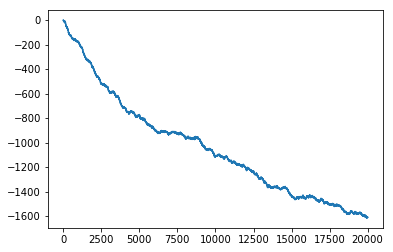

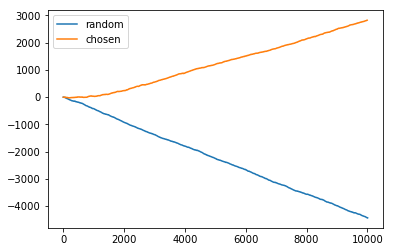

In [393]:
plt.figure(1)
plt.plot(np.cumsum(games))

plt.figure(2)
plt.plot(np.cumsum(random_games), label="random")
plt.plot(np.cumsum(chosen_games), label="chosen")
plt.legend(loc=0)

plt.show()

In [394]:
# Mean rounds duration
for play_type in ['random_play', 'chosen_play']:
    print "--- "+str(play_type)
    for player_sequence in ['player_first', 'player_second']:
        nb_plays = plays_description[play_type][player_sequence]['win'] + plays_description[play_type][player_sequence]['loss']
        print player_sequence, plays_description[play_type][player_sequence]['#rounds'] / float(nb_plays)

--- random_play
player_first 5.17856428714
player_second 5.39424805273
--- chosen_play
player_first 5.79778894472
player_second 5.59617301176


In [190]:
model

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [191]:
# statistical interpretation of the results
